##### Pipelines and Grid Search Cross Validation

Building powerful models is all about feature engineering and hyperparameter optimization. If we are going to efficiently iterate through many different models we need to automate the process of trying hyperparameters and evaluating the result. As you will see sklearn Pipelines are a powerful paradigm for doing just that.   

Pipelines allow you, the researcher, to chain many feature engineering steps together, (along with your sklearn estimator) and optimize your models using GridSearchCV automatically!      


In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets, model_selection, linear_model, preprocessing, pipeline, metrics

import matplotlib.pyplot as plt

%matplotlib inline

Frist we will read in the standard Boston Housing Price dataset. Details of this dataset are not particularly important for our purposes, but we are basically using Regression to predict the value of a home in Boston given details about the home itself and it’s neighborhood .    

In [4]:
dset = datasets.load_boston()

df = pd.DataFrame(data=dset.data, columns= dset.feature_names)
df['y'] = dset.target

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
#Create a train test split
df_train, df_test = model_selection.train_test_split(df,test_size=0.1)

We will plan to Normilze the data, apply some Polynomial Feature engineering and train an ElasticNet linear regressor on the dataset.

In [8]:
#Construct the StandardScaler
norm = preprocessing.StandardScaler(with_mean=True, with_std=True)

#Generate polynomial features
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=True)

#Seteup our Regressor
regresor = linear_model.ElasticNet(alpha=1.0 )

Finding the right hyperatmers to train our classifyer means building many StandardScaler's, many PolynomialFeatures exractors and many ElasticNet nets and trying them in combination to find the best one. This would be error prone and major pain.

###### Pipeline API
Now the magic: we can chain these operations into a 'pipeline' that acts as a single estimator, running normalization, polynomial feature engineering and repressor automatically after every call to fit or fit_transform. Look around at the pipeline module in sklearn on your own before proceeding.

In [9]:
myPipeline = pipeline.Pipeline([ ('norm', norm),
                                 ('poly',poly),
                                 ('regresor', regresor)
                               ])

With a pipeline in hand we can now preform a cross validated grid search for the optimal hyper parameters in each stage of our ML pipeline. In our dictionary of paramters to try we use the following notation:
<ol>
<li> stage name of the pipeline </li>
<li> two (2) underscores like "stageName__" </li>
<li> the name of the hyperamater. </li>
</ol>
Fro example to check the "with_mean" hyperapater of the StandardScaler stage we have named "norm", the syntax would be "norm__with_mean".

The rest is just vanalla Gridsearch!

In [10]:
grid = {'norm__with_mean':[True, False],
        'poly__degree':[1,2,3],
        'regresor__alpha':[0.001,0.01,0.1,1,10]}

gs = model_selection.GridSearchCV( estimator=myPipeline,
                                   param_grid= grid,
                                   cv = 3,
                                   scoring= metrics.make_scorer(metrics.r2_score)
                                )

In [11]:
tar_cols = [c for c in df_test.columns if c!='y']

fit_model = gs.fit(df_train[tar_cols], df_train['y'])

/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Get the best estimator from our Gridsearch and run it against the testing data to see how we are doing.

In [13]:
best_model = gs.best_estimator_

score_train = best_model.score(df_train[tar_cols], df_train['y'])
score_test = best_model.score(df_test[tar_cols], df_test['y'])

print('R2 on training data: %f'%(score_train))
print('R2 on testing data : %f'%(score_test))

R2 on training data: 0.914958
R2 on testing data : 0.865398


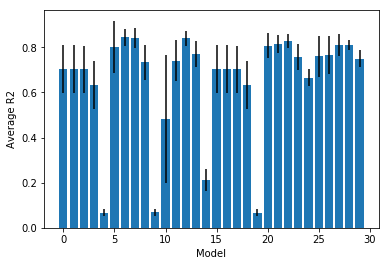

In [23]:
avg_test = gs.cv_results_['mean_test_score']
std_test = 2.*gs.cv_results_['std_test_score']
v=np.arange(0,avg_test.shape[0])
plt.bar(v,avg_test,yerr=std_test)
plt.ylabel('Average R2')
plt.xlabel('Model')
plt.show()

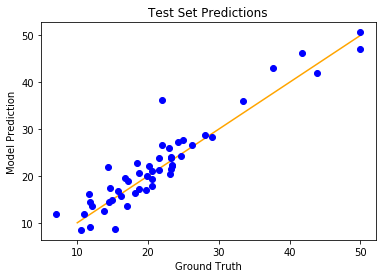

In [24]:
xs = np.arange(10,50,0.01)
preds = fit_model.best_estimator_.predict(df_test[tar_cols])
#plt.xlim([10,50])
plt.plot(xs,xs,'orange')
plt.plot(df_test['y'],preds,'bo')
plt.ylabel('Model Prediction')
plt.xlabel('Ground Truth')
plt.title('Test Set Predictions')
plt.show()